# Electron Photon tagging

This is a first test to implement a QAE. 
The task is to identify Electrons and Photons from em-calorimeter images.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
import tensorflow as tf
import tensorflow_quantum as tfq
from hep_VQAE import data_preprocessing as dp


import warnings
warnings.filterwarnings('ignore')

2022-06-28 16:35:01.251209: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-28 16:35:01.251238: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-06-28 16:35:03.299018: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-28 16:35:03.299054: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-28 16:35:03.299078: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tomskopfbahnhof): /proc/driver/nvidia/version does not exist
2022-06-28 16:35:03.299398: I tensorflow/core/platform/cpu_fe

In [2]:
data = np.load('data/electron-photon.npz', allow_pickle=True)
x_train = data['x_train']
x_test = data['x_test']
y_train = data['y_train']
y_test = data['y_test']
print("x_train: ", x_train.shape)
print("x_test: ", x_test.shape)
print("y_train: ", y_train.shape)
print("y_test: ", y_test.shape)

x_train:  (100, 32, 32)
x_test:  (100, 32, 32)
y_train:  (100,)
y_test:  (100,)


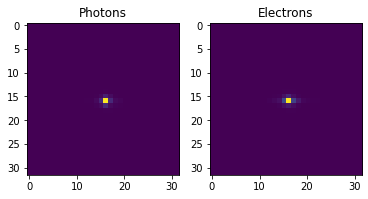

In [3]:
fig, axs = plt.subplots(1,2)

axs[0].imshow(np.average(x_train[y_train==0],0))
axs[0].title.set_text('Photons')

axs[1].imshow(np.average(x_train[y_train==1],0))
axs[1].title.set_text('Electrons')

# Dimensionality reduction

To use the QAE we need to reduce the dimension as only a couple of qbits are available.
The easiest way is a simple PCA.

In [4]:
DOWNSCALE = 2
DATA_DIMENSION = DOWNSCALE*DOWNSCALE
LATENT_BITS = 2

x_train, x_test = dp.PCA_reduce(x_train, DATA_DIMENSION, val_data=x_test)
print(np.max(x_train))
print(np.min(x_train))
print(x_train.shape)
print(x_test.shape)

1.0
0.0
(100, 4)
(100, 4)


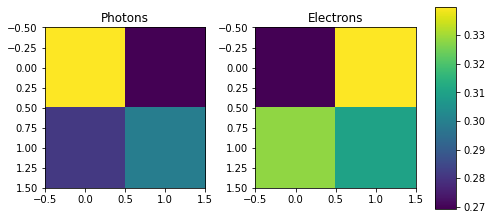

In [5]:
fig, axs = plt.subplots(1,2)
img0 = axs[0].imshow(np.average(x_train[y_train==0],0).reshape(DOWNSCALE,DOWNSCALE))
axs[0].title.set_text('Photons')

img1 = axs[1].imshow(np.average(x_train[y_train==1],0).reshape(DOWNSCALE,DOWNSCALE))
axs[1].title.set_text('Electrons')

cbar_ax = fig.add_axes([1, 0.15, 0.05, 0.7])
fig.colorbar(img1, orientation='vertical', cax=cbar_ax)

fig.tight_layout()

After the PCA it looks like Photons and Electrons should still seperate quite well.

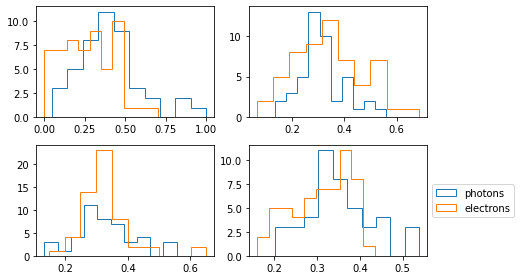

In [6]:
fig, axs = plt.subplots(DOWNSCALE,DOWNSCALE)
for i in range(0,DATA_DIMENSION):
    axs[i//DOWNSCALE,i%DOWNSCALE].hist(x_train[y_train==0][:,i], label="photons", histtype='step')
    axs[i//DOWNSCALE,i%DOWNSCALE].hist(x_train[y_train==1][:,i], label="electrons", histtype='step')
fig.tight_layout()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

I want only want to train the AE on Photons and later try to separate them from the electrons without training on electron data.
Therefore I only include Photons in x_train.


In [7]:
x_train_electrons = x_train[y_train==1]
x_train = x_train[y_train==0]

x_test_electrons = x_test[y_test==1]
x_test = x_test[y_test==0]

In [8]:
dp.input_states(x_train[0],DATA_DIMENSION,LATENT_BITS)

(0, 0): ───X^0.3072941───────────────────

(0, 1): ───X^0.17775053──────────────────

(0, 2): ───X^0.30853552──────────────────

(0, 3): ───X^0.26657757──────────────────

(0, 6): ──────────────────X^0.3072941────

(0, 7): ──────────────────X^0.17775053───

(0, 8): ──────────────────X^0.30853552───

(0, 9): ──────────────────X^0.26657757───

# QAE

First simple implementation of a QAE

In [9]:
x_train_circuit = [dp.input_states(x,DATA_DIMENSION,LATENT_BITS) for x in x_train]
x_test_circuit = [dp.input_states(x,DATA_DIMENSION,LATENT_BITS) for x in x_test]

x_train_circuit_electrons = [dp.input_states(x,DATA_DIMENSION,LATENT_BITS) for x in x_train_electrons]
x_test_circuit_electrons = [dp.input_states(x,DATA_DIMENSION,LATENT_BITS) for x in x_test_electrons]

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


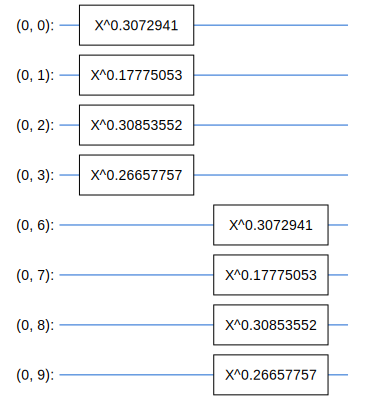

In [10]:
SVGCircuit(x_train_circuit[0])

In [11]:
x_train_tf = tfq.convert_to_tensor(x_train_circuit)
x_test_tf = tfq.convert_to_tensor(x_test_circuit)

x_train_tf_electrons = tfq.convert_to_tensor(x_train_circuit_electrons)
x_test_tf_electrons = tfq.convert_to_tensor(x_test_circuit_electrons)

In [12]:
from hep_VQAE import QAE as qae

model = tf.keras.Sequential([
                             
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    
    # The PQC stands for Paramaterized Quantum Circuit
    # This returns the expectation value
    qae.QAE_layer(DATA_DIMENSION, LATENT_BITS, 7),
])

In [13]:
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lr=0.01))

In [14]:
y_train_ones = np.ones(shape=len(x_train_tf))
y_test_ones = np.ones(shape=len(x_test_tf))

y_train_ones_electrons = np.ones(shape=len(x_train_tf_electrons))
y_test_ones_electrons = np.ones(shape=len(x_test_tf_electrons))

In [15]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)
history = model.fit(x_train_tf, y_train_ones, epochs=400, batch_size=16, validation_data=(x_test_tf, y_test_ones), callbacks=[es])

Epoch 1/400
3/3 [==============================] - 1s 243ms/step - loss: 0.9004 - val_loss: 0.8687
Epoch 2/400
3/3 [==============================] - 0s 166ms/step - loss: 0.8695 - val_loss: 0.8348
Epoch 3/400
3/3 [==============================] - 0s 166ms/step - loss: 0.8319 - val_loss: 0.7965
Epoch 4/400
3/3 [==============================] - 0s 162ms/step - loss: 0.7909 - val_loss: 0.7549
Epoch 5/400
3/3 [==============================] - 0s 168ms/step - loss: 0.7458 - val_loss: 0.7116
Epoch 6/400
3/3 [==============================] - 0s 169ms/step - loss: 0.6989 - val_loss: 0.6669
Epoch 7/400
3/3 [==============================] - 0s 163ms/step - loss: 0.6503 - val_loss: 0.6222
Epoch 8/400
3/3 [==============================] - 0s 170ms/step - loss: 0.6022 - val_loss: 0.5775
Epoch 9/400
3/3 [==============================] - 0s 166ms/step - loss: 0.5536 - val_loss: 0.5335
Epoch 10/400
3/3 [==============================] - 0s 170ms/step - loss: 0.5071 - val_loss: 0.4894
Epoch 11/

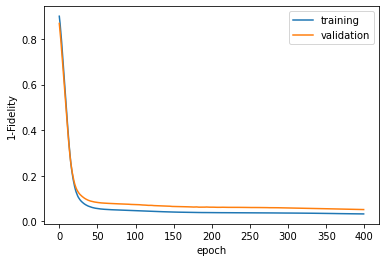

In [16]:
plt.plot(history.history['loss'], label="training")
plt.plot(history.history['val_loss'], label="validation")
#plt.yscale('log')
plt.xlabel("epoch")
plt.ylabel("1-Fidelity")
plt.legend()

0.81971276
0.8450857


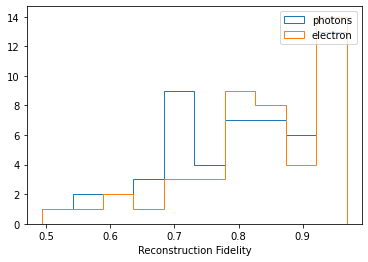

In [17]:
pred_photon = model.predict(x_test_tf)
print(np.median(pred_photon))
pred_electron = model.predict(x_test_tf_electrons)
print(np.median(pred_electron))
bins = np.histogram(np.hstack((pred_photon.reshape((pred_photon.shape[0],)), pred_electron.reshape((pred_electron.shape[0],)))), bins=10)[1]
plt.hist(pred_photon, histtype='step', label="photons",bins=bins)
plt.hist(pred_electron, histtype='step', label="electron",bins=bins)
plt.xlabel("Reconstruction Fidelity")
plt.legend()

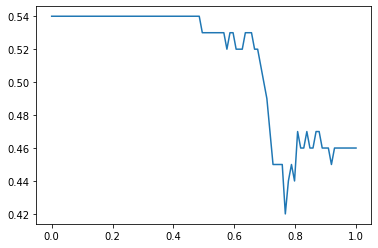

In [18]:
def acc_for_threshold(T):
    # sixes that are predicted six
    num_six_right = np.sum(pred_photon > T)
    # threes that are predicted three
    num_three_right = np.sum(pred_electron < T)
    acc = (num_six_right + num_three_right)/(len(pred_photon) + len(pred_electron))
    return acc

Ts = np.linspace(0,1,100)
accs = []
for i in Ts:
    accs.append(acc_for_threshold(i))
plt.plot(Ts, accs)  